# NY特定地域のタクシー運賃予測
乗車位置の緯度経度、降車位置の緯度軽度から運賃(米ドル)を推測


## データの準備

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pdp

In [3]:
data = pd.read_csv("data/data_10k.csv")

## データの概要や、基礎統計量の確認
pandas_profilingを使う。

In [7]:
profile = pdp.ProfileReport(data)
# profileのみでも表示可能,to_widgets()の方がコンパクトでノートブック向き
profile.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

ちなみに、htmlファイルとしても出力・保存することも可能。

In [8]:
# notebook中にhtmlとして表示
# profile.to_notebook_iframe()

# htmlとして出力
# profile.to_file("my_report.html")

従属変数であるfare_amountについて、外れ値のせいでヒストグラムが見づらくなっているため、個別で作成。

<AxesSubplot:>

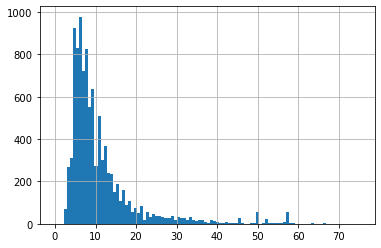

In [12]:
# bins=100 で100分割
data.fare_amount.hist(bins=100, range=(0, 75))

45や50、58あたりで、直感に反するデータが存在する。これらのデータにあって、他のデータにはない特徴を調査することは有益である。

また、fare_amountのminが-2.9になっている。これはデータ上妥当なのかを確認する必要がある。

## ノイズ除去
NY周辺の緯度経度に限定する。

In [13]:
# NYを囲む四角を設定
ny_left = -74.2632
ny_right = -72.9856
ny_top = 41.0590
ny_bottom = 40.5690

これを用いて、criteriaを作成

In [19]:
criteria = (data.pickup_latitude.between(ny_bottom, ny_top)
& data.pickup_longitude.between(ny_left, ny_right)
& data.dropoff_latitude.between(ny_bottom, ny_top)
& data.dropoff_longitude.between(ny_left, ny_right))
criteria

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Length: 10000, dtype: bool

ノイズを除去し、以降はclean_dataを用いる。

In [21]:
clean_data = data[criteria]

## 散布図・二次元ヒストグラム

pdpの散布図では分かりづらいため、個別に作成する。

Text(0.5, 1.0, 'dropoff')

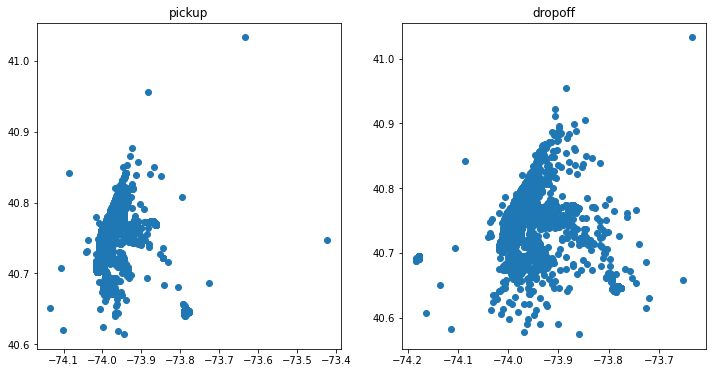

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(clean_data.pickup_longitude, clean_data.pickup_latitude)
axes[0].set_title("pickup")
axes[1].scatter(clean_data.dropoff_longitude, clean_data.dropoff_latitude)
axes[1].set_title("dropoff")

もう少し直感的に理解するため、背景に地図画像を挿入する。

In [27]:
# まだ用意できていないです
# nyc_map = plt.imread("nyc_map.png")

Text(0.5, 1.0, 'dropoff')

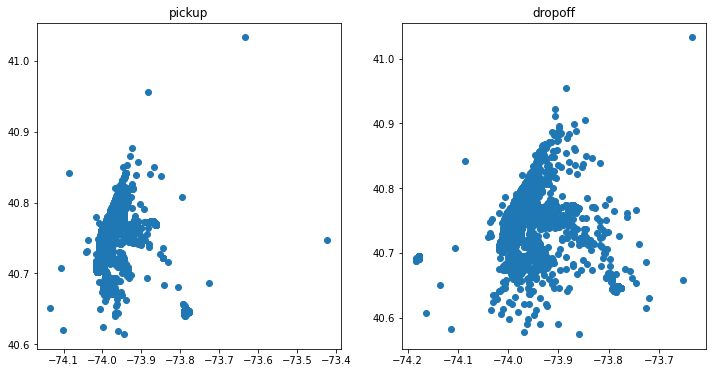

In [28]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(clean_data.pickup_longitude, clean_data.pickup_latitude)
# axes[0].imshow(nyc_map, extent=(ny_left, ny_right, ny_bottom, ny_top))
axes[0].set_title("pickup")
axes[1].scatter(clean_data.dropoff_longitude, clean_data.dropoff_latitude)
# axes[1].imshow(nyc_map, extent=(ny_left, ny_right, ny_bottom, ny_top))
axes[1].set_title("dropoff")


地図を重ねてみると、マンハッタンの中心部から郊外へ移動している人が一定数いることがわかる。

今度は、hist2dを用いてデータ数の密度も可視化してみる。hist2dは、散布図の領域を区分けして、それぞれの区分に属する点の個数を数え上げ色をつける。

今回、bins=100, alpha=0.5にすることでより細かく、見やすくする。また、cmin=50にして一つのセルのデータ数が50に満たないセルは表示しないようにすることで、さらに見やすくする。

加えて、set_xlimやset_ylimでズームアップを行う。

Text(0.5, 1.0, 'dropoff')

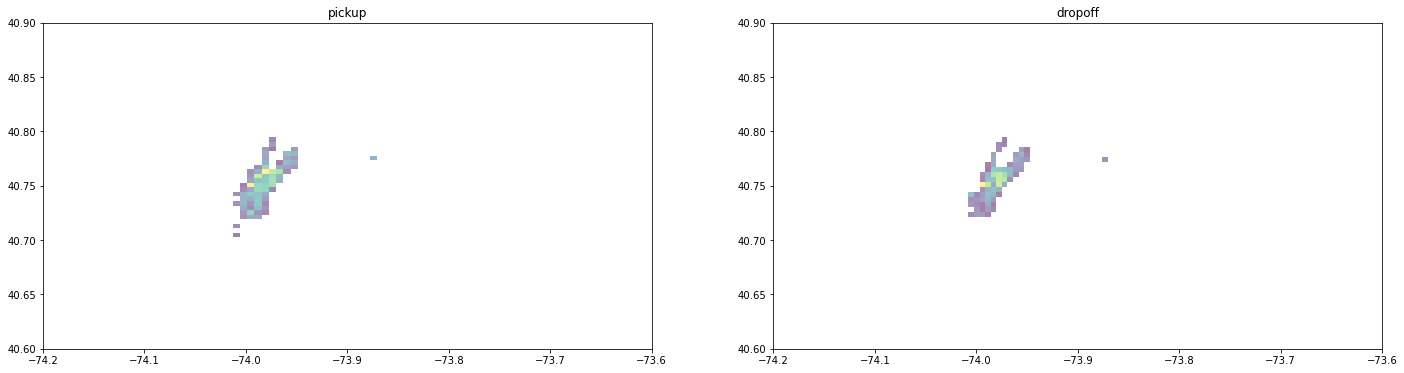

In [33]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

axes[0].hist2d(clean_data.pickup_longitude,
               clean_data.pickup_latitude, bins=100, alpha=0.5, cmin=50)
# axes[0].imshow(nyc_map, extent=(ny_left, ny_right, ny_bottom, ny_top))
axes[0].set_xlim(-74.2, -73.6)
axes[0].set_ylim(40.6, 40.9)
axes[0].set_title("pickup")

axes[1].hist2d(clean_data.dropoff_longitude,
               clean_data.dropoff_latitude, bins=100, alpha=0.5, cmin=50)
# axes[1].imshow(nyc_map, extent=(ny_left, ny_right, ny_bottom, ny_top))
axes[1].set_xlim(-74.2, -73.6)
axes[1].set_ylim(40.6, 40.9)
axes[1].set_title("dropoff")


地図と照らし合わせると、pickupにおいて空港での利用者が一定数いることがわかる。空港からマンハッタンに向けて移動する人が多いのではないかと推測できる。

## クラスタ分析
データ全体を見るだけでは気づけなかった新たな気づきが得られるかもしれない。

ニューヨークセンター、ラガーリア空港、JFK空港の3つのクラスタに手動で分ける。

In [39]:
nyc_lat, nyc_lon = 40.76, -73.98
nyc_cluster = (
    clean_data.pickup_latitude.between(nyc_lat-0.05, nyc_lat+0.05)&
    clean_data.pickup_longitude.between(nyc_lon-0.05, nyc_lon+0.05)
)
len(clean_data[nyc_cluster])

8906

In [40]:
lgr_lat, lgr_lon = 40.77, -73.87
lgr_cluster = (
    clean_data.pickup_latitude.between(lgr_lat-0.05, lgr_lat+0.05) &
    clean_data.pickup_longitude.between(lgr_lon-0.05, lgr_lon+0.05)
)
len(clean_data[lgr_cluster])

259

In [42]:
jfk_lat, jfk_lon = 40.64, -73.78
jfk_cluster = (
    clean_data.pickup_latitude.between(jfk_lat-0.05, jfk_lat+0.05) &
    clean_data.pickup_longitude.between(jfk_lon-0.05, jfk_lon+0.05)
)
len(clean_data[jfk_cluster])

156

各クラスターの散布図を作成してみる。この時、range=(0, 100)としてx軸の範囲を揃える

<AxesSubplot:>

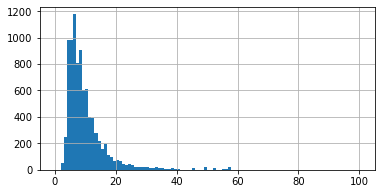

In [55]:
clean_data[nyc_cluster].fare_amount.hist(
    bins=100, figsize=(6, 3), range=(0, 100))


<AxesSubplot:>

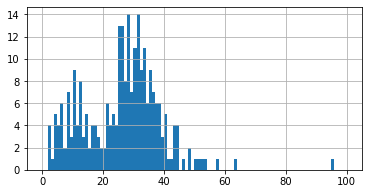

In [52]:
clean_data[lgr_cluster].fare_amount.hist(
    bins=100, figsize=(6, 3), range=(0, 100))

データ数が少ないので信頼性は低いが、山が二つあるように見える。

<AxesSubplot:>

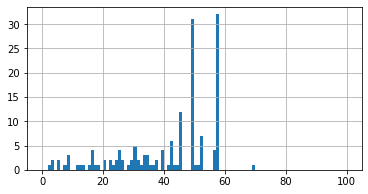

In [53]:
clean_data[jfk_cluster].fare_amount.hist(
    bins=100, figsize=(6, 3), range=(0, 100))


山が存在せず、一定の値に集中している。
→ JFK空港発のタクシーでは、定額制のタクシーがあるのではないかと推測できる。

## 不完全な数式を考案、補完

リッジ回帰を考案

In [56]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)


データを独立変数と従属変数に分けたのち、リッジ回帰を補完する。


In [71]:
from sklearn.model_selection import train_test_split
df = clean_data
y_col = "fare_amount"
X = df.drop(columns=[y_col])
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

clf.fit(X_train, y_train)

Ridge()

In [72]:
clf.coef_, X.columns, clf.intercept_

(array([-41.78724266,  91.47879546, -33.19805105,  63.02326913]),
 Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
        'dropoff_longitude'],
       dtype='object'),
 14496.244978140587)

## 評価
問題設定の効果測定に適した指標を決める。

ひとまず、差分を確認してみる。

In [74]:
diff = pd.DataFrame({
    "true":y_test,
    "pred": clf.predict(X_test)
})
diff

,true,pred
4546,14.5,10.538765
9698,9.0,8.946383
7850,5.3,12.150330
4970,7.5,10.133227
4044,8.5,10.186212
...,...,...
3978,7.0,10.730169
8357,6.5,12.063235
9511,5.0,7.694617
2149,12.0,10.931173


RSMEを用いて計算

In [75]:
def rmse(true_y, pred_y):
    return np.sqrt(((true_y - pred_y)**2).mean())

rmse(diff["true"], diff["pred"])

7.820438143124702

これは目標精度に届いていないので、数式を見直す

## 数式の補完を見直す
ハイパラを変えてみよう

## 数式の特徴量を見直す
工夫しよう

## 用いる数式自体を見直す
xgboostを使ってみよう

## まとめ
データ分析は、泥臭さが必要とされるのです。